# <center>Бинарная классификация и отправка на Kaggle

In [250]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import numpy as np
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from collections import Counter
from sklearn.utils import resample
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
warnings.filterwarnings("ignore")

In [251]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

### Посмотрим на данные

In [252]:
train.head()

,id,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,...,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
0,4719,28,20.30,487.95,Male,0,Yes,Yes,Yes,No,...,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,Yes,Credit card (automatic),0
1,3190,12,81.45,912,Male,0,No,No,Yes,No,...,No,No,No,No,Yes,No,Month-to-month,Yes,Electronic check,0
2,5215,25,20.15,536.35,Male,0,No,No,Yes,No,...,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,Yes,Mailed check,0
3,1472,50,69.50,3418.2,Male,0,No,No,Yes,Yes,...,No,No,Yes,Yes,No,Yes,Two year,No,Bank transfer (automatic),0
4,4413,39,101.25,3949.15,Female,1,Yes,No,Yes,Yes,...,No,No,No,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,0


In [253]:
test.head()

,id,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod
0,2258,46,55.65,2688.85,Female,0,No,No,Yes,No,DSL,No,No,No,No,No,Yes,One year,No,Credit card (automatic)
1,3864,48,78.75,3682.45,Male,0,No,Yes,Yes,Yes,DSL,Yes,No,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic)
2,1391,7,69.20,477.55,Female,0,Yes,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Bank transfer (automatic)
3,486,3,75.15,216.75,Female,0,Yes,No,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Credit card (automatic)
4,970,14,19.35,324.8,Male,0,No,No,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check


Датасеты train и test отличаются толькой одной колонкой - той, что надо предсказать. 
Посмотрим на количество пропусков в каждой колонке

In [254]:
train.isna().any(axis=1).sum()

0

In [255]:
test.isna().any(axis=1).sum()

0

Вообще, isna находит не все пропуски. 
Например, если внезапно численная переменная вдруг становится строкой - это звоночек, что там есть какие-то проблемы.
Поэтому рекомендуется у строк, которые не являются численными (int64, float64), выводить уникальные значения. 
Там и можно обнаружить пропуски

### Посмотрим на тип данных каждой из колонок

In [256]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3169 entries, 0 to 3168
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        3169 non-null   int64  
 1   ClientPeriod              3169 non-null   int64  
 2   MonthlySpending           3169 non-null   float64
 3   TotalSpent                3169 non-null   object 
 4   Sex                       3169 non-null   object 
 5   IsSeniorCitizen           3169 non-null   int64  
 6   HasPartner                3169 non-null   object 
 7   HasChild                  3169 non-null   object 
 8   HasPhoneService           3169 non-null   object 
 9   HasMultiplePhoneNumbers   3169 non-null   object 
 10  HasInternetService        3169 non-null   object 
 11  HasOnlineSecurityService  3169 non-null   object 
 12  HasOnlineBackup           3169 non-null   object 
 13  HasDeviceProtection       3169 non-null   object 
 14  HasTechS

In [257]:
train.describe()

,id,ClientPeriod,MonthlySpending,IsSeniorCitizen,Churn
count,3169.000000,3169.000000,3169.000000,3169.000000,3169.000000
mean,2658.504891,31.855790,65.157715,0.162512,0.265068
std,1536.114959,24.471827,29.921808,0.368978,0.441439
min,1.000000,0.000000,18.250000,0.000000,0.000000
25%,1330.000000,8.000000,39.200000,0.000000,0.000000
50%,2635.000000,28.000000,70.700000,0.000000,0.000000
75%,4027.000000,54.000000,89.850000,0.000000,1.000000
max,5279.000000,72.000000,118.650000,1.000000,1.000000


In [258]:
# здесь есть ловушка, поищите
# Числовые признаки
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'IsSeniorCitizen'
]

# Категориальные признаки
cat_cols = [
    'Sex',
    'HasPartner',
    'TotalSpent',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

feature_cols = num_cols
target_col = 'Churn'

В sklearn большинство моделей не обрабатывают категориальные признаки.
А у нас они есть... поэтому вспоминаем первую практическую и обрабатываем категориальные признаки.
Также, мы применяли one-hot encoding к категориальным признакам, потому что с label-encoding в случае 3 и более значений образовывались операции +- над категориями. 
Но вспомним, что после one-hot encoding мы получали бинарные данные, а некоторые из признаков и так уже бинарные.

А еще можно обрабатывать числовые признаки. Можно же?

## Обработка

In [259]:
for i in cat_cols:
    print(f'{i} - {train[i].unique()}')

Sex - ['Male' 'Female']
HasPartner - ['Yes' 'No']
TotalSpent - ['487.95' '912' '536.35' ... '3454.6' '3092.65' '1043.8']
HasChild - ['Yes' 'No']
HasPhoneService - ['Yes' 'No']
HasMultiplePhoneNumbers - ['No' 'Yes' 'No phone service']
HasInternetService - ['No' 'Fiber optic' 'DSL']
HasOnlineSecurityService - ['No internet service' 'No' 'Yes']
HasOnlineBackup - ['No internet service' 'No' 'Yes']
HasDeviceProtection - ['No internet service' 'No' 'Yes']
HasTechSupportAccess - ['No internet service' 'No' 'Yes']
HasOnlineTV - ['No internet service' 'Yes' 'No']
HasMovieSubscription - ['No internet service' 'No' 'Yes']
HasContractPhone - ['Two year' 'Month-to-month' 'One year']
IsBillingPaperless - ['Yes' 'No']
PaymentMethod - ['Credit card (automatic)' 'Electronic check' 'Mailed check'
 'Bank transfer (automatic)']


Видим что столбец TotalSpent является числовым

In [260]:
def num_unique(data: pd.core.frame.DataFrame, column: str) -> set:
    """
    Функция поиска уникальных значений среди чисел
    :param data: датафрейм
    :type data: pd.core.frame.DataFrame
    :param column: название столбца
    :type column: str
    :return: множество уникальных значений
    :rtype: set
    """
    nan = set()
    for item in data[column]:
        if not ('.' or ',') in item and not item.isdigit():
            nan.add(item)
    return nan


In [261]:
num_unique(train, 'TotalSpent')

{' '}

In [262]:
def process_data(data: pd.core.frame.DataFrame, categorial: list[str]) -> pd.core.frame.DataFrame:
    """
    Функция обработки качественных признаков
    и стандартизации количественных признаков.
    
    :param data: Датафрейм для обработки
    :type data: DataFrame
    :param cat_cols: Список качественных признаков
    :type cat_cols: list
    :return: Обработанный датафрейм
    :rtype: DataFrame
    """
    scaler = StandardScaler()
    enc = OneHotEncoder()
    data['TotalSpent'] = data['TotalSpent'].replace({' ': np.nan})
    data['TotalSpent'] = data['TotalSpent'].fillna(data['TotalSpent'].median()).astype('float')
    data[['ClientPeriod', 'TotalSpent', 'MonthlySpending']] = \
        scaler.fit_transform(data[['ClientPeriod', 'TotalSpent', 'MonthlySpending']])
    enc_data = pd.DataFrame(enc.fit_transform(data[['PaymentMethod']]).toarray(),
                            columns=data['PaymentMethod'].unique())
    data = data.join(enc_data)
    data.drop('PaymentMethod', axis=1, inplace=True)
    data[categorial] = data[categorial].apply(LabelEncoder().fit_transform)    
    return data

Заменяем нечисловые значения и приводим к float

In [263]:
cat_cols.remove('PaymentMethod')
train = process_data(train, cat_cols)
test = process_data(test, cat_cols)

In [264]:
train

,id,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,...,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,Churn,Credit card (automatic),Electronic check,Mailed check,Bank transfer (automatic)
0,4719,-0.157585,-1.499401,789,1,0,1,1,1,0,...,1,1,1,2,1,0,0.0,1.0,0.0,0.0
1,3190,-0.811502,0.544581,1131,1,0,0,0,1,0,...,0,2,0,0,1,0,0.0,0.0,1.0,0.0
2,5215,-0.280195,-1.504415,834,1,0,0,0,1,0,...,1,1,1,0,1,0,0.0,0.0,0.0,1.0
3,1472,0.741550,0.145144,2172,1,0,0,0,1,2,...,2,0,2,2,0,0,1.0,0.0,0.0,0.0
4,4413,0.291982,1.206410,2304,0,1,1,0,1,2,...,2,2,2,0,1,0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3164,3483,-1.220199,0.494443,406,1,0,0,0,1,0,...,0,2,0,0,1,0,0.0,0.0,1.0,0.0
3165,3555,-0.648022,0.290546,1383,1,0,1,0,1,2,...,0,0,0,0,1,1,1.0,0.0,0.0,0.0
3166,2292,0.741550,0.173556,2180,1,1,0,0,1,2,...,0,2,0,0,1,0,1.0,0.0,0.0,0.0
3167,960,0.905029,-0.339529,2080,1,0,0,1,1,2,...,0,0,0,0,1,1,0.0,1.0,0.0,0.0


In [265]:
test

,id,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,...,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,Credit card (automatic),Bank transfer (automatic),Mailed check,Electronic check
0,2258,0.519016,-0.292147,1342,0,0,0,0,1,0,...,0,0,0,2,1,0,0.0,1.0,0.0,0.0
1,3864,0.600167,0.463967,1495,1,0,0,1,1,2,...,2,0,2,2,1,1,0.0,1.0,0.0,0.0
2,1391,-1.063437,0.151374,549,0,0,1,0,1,0,...,0,0,0,0,0,1,1.0,0.0,0.0,0.0
3,486,-1.225740,0.346131,321,0,0,1,0,1,2,...,0,0,0,0,0,1,0.0,1.0,0.0,0.0
4,970,-0.779407,-1.480325,435,1,0,0,0,1,0,...,1,1,1,1,1,0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2108,1700,-1.306891,-0.491813,76,0,0,0,0,1,0,...,0,0,0,0,0,0,1.0,0.0,0.0,0.0
2109,1865,-0.576529,0.059724,965,1,1,1,0,1,0,...,2,0,2,0,0,0,1.0,0.0,0.0,0.0
2110,478,1.492833,0.046631,1679,0,0,0,1,1,2,...,0,2,0,0,2,0,0.0,0.0,1.0,0.0
2111,1227,-0.941710,0.999138,764,1,0,0,0,1,0,...,0,2,2,2,0,1,0.0,1.0,0.0,0.0


In [266]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3169 entries, 0 to 3168
Data columns (total 24 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         3169 non-null   int64  
 1   ClientPeriod               3169 non-null   float64
 2   MonthlySpending            3169 non-null   float64
 3   TotalSpent                 3169 non-null   int64  
 4   Sex                        3169 non-null   int32  
 5   IsSeniorCitizen            3169 non-null   int64  
 6   HasPartner                 3169 non-null   int32  
 7   HasChild                   3169 non-null   int32  
 8   HasPhoneService            3169 non-null   int32  
 9   HasMultiplePhoneNumbers    3169 non-null   int32  
 10  HasInternetService         3169 non-null   int32  
 11  HasOnlineSecurityService   3169 non-null   int32  
 12  HasOnlineBackup            3169 non-null   int32  
 13  HasDeviceProtection        3169 non-null   int32

Построим матрицу коррелирующих признаков

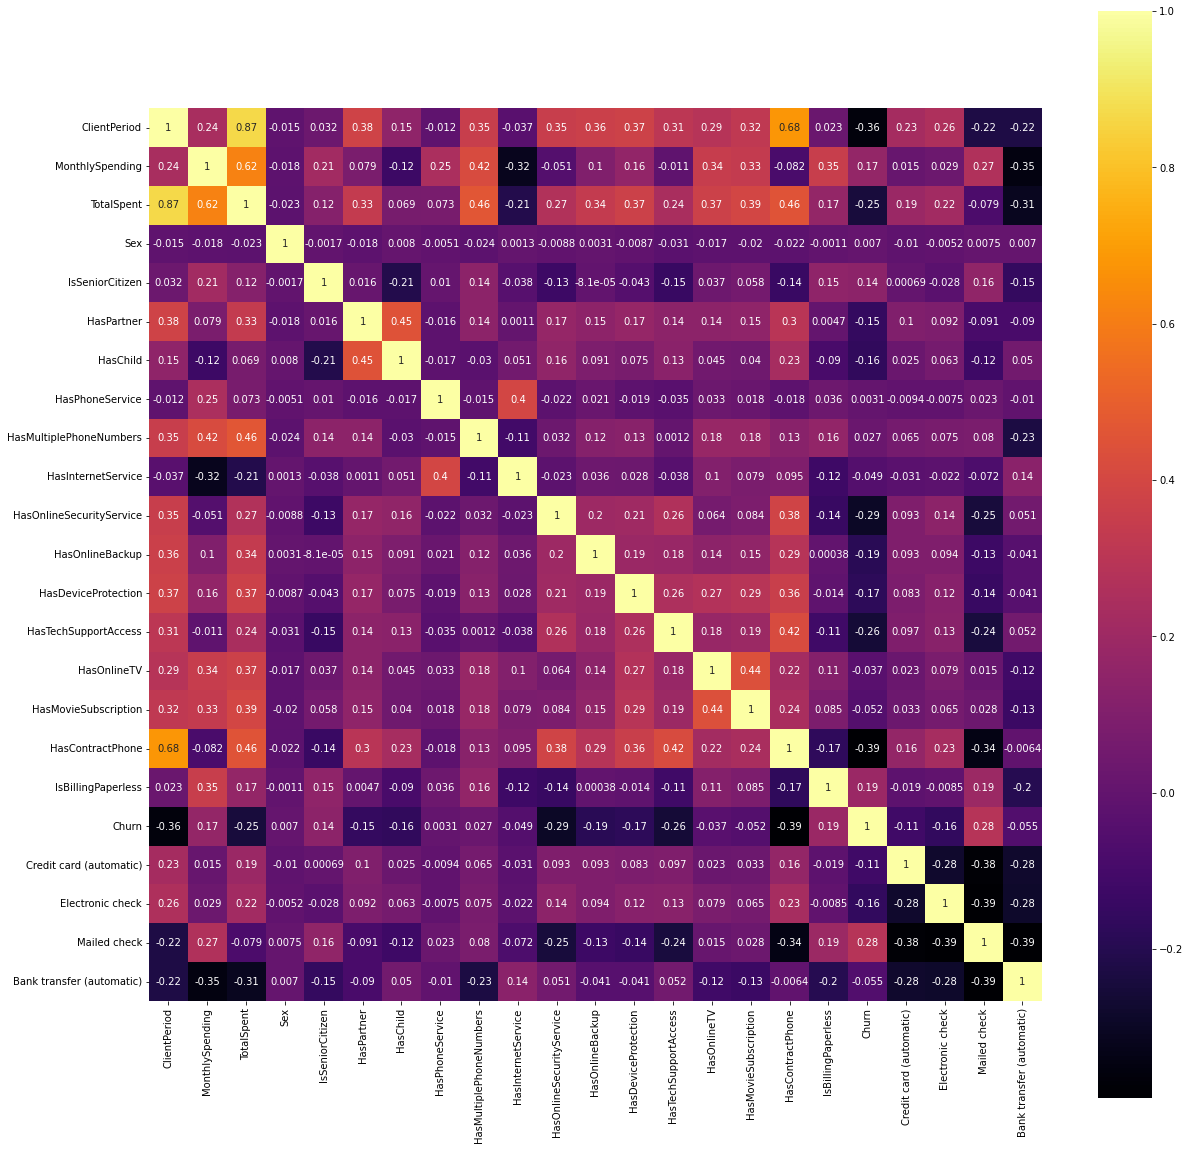

In [267]:
colormap = plt.cm.inferno
plt.figure(figsize=(20, 20))
sns.heatmap(train.drop('id', axis=1).corr(),
            square=True, annot=True, cmap=colormap)
plt.show()

Удалим сильно коррелирующие признаки

In [268]:
train = train.drop('ClientPeriod', axis=1)
test = test.drop('ClientPeriod', axis=1)
num_cols.remove('ClientPeriod')

In [269]:
train


,id,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,...,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,Churn,Credit card (automatic),Electronic check,Mailed check,Bank transfer (automatic)
0,4719,-1.499401,789,1,0,1,1,1,0,2,...,1,1,1,2,1,0,0.0,1.0,0.0,0.0
1,3190,0.544581,1131,1,0,0,0,1,0,1,...,0,2,0,0,1,0,0.0,0.0,1.0,0.0
2,5215,-1.504415,834,1,0,0,0,1,0,2,...,1,1,1,0,1,0,0.0,0.0,0.0,1.0
3,1472,0.145144,2172,1,0,0,0,1,2,0,...,2,0,2,2,0,0,1.0,0.0,0.0,0.0
4,4413,1.206410,2304,0,1,1,0,1,2,1,...,2,2,2,0,1,0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3164,3483,0.494443,406,1,0,0,0,1,0,1,...,0,2,0,0,1,0,0.0,0.0,1.0,0.0
3165,3555,0.290546,1383,1,0,1,0,1,2,1,...,0,0,0,0,1,1,1.0,0.0,0.0,0.0
3166,2292,0.173556,2180,1,1,0,0,1,2,0,...,0,2,0,0,1,0,1.0,0.0,0.0,0.0
3167,960,-0.339529,2080,1,0,0,1,1,2,0,...,0,0,0,0,1,1,0.0,1.0,0.0,0.0


In [270]:
cols = num_cols + cat_cols

In [271]:
x = train[cols]
y = train[target_col]

In [272]:
x_train, x_val, y_train, y_val = train_test_split(x, y, train_size=0.7)

In [273]:
def roc_auc_plot(y_train, y_train_predicted, y_val, y_val_predicted) -> None:
    train_auc = roc_auc_score(y_train, y_train_predicted)
    test_auc = roc_auc_score(y_val, y_val_predicted)

    plt.figure(figsize=(10,7))
    plt.plot(*roc_curve(y_train, y_train_predicted)[:2], label='train AUC={:.4f}'.format(train_auc))
    plt.plot(*roc_curve(y_val, y_val_predicted)[:2], label='test AUC={:.4f}'.format(test_auc))
    legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
    legend_box.set_facecolor("white")
    legend_box.set_edgecolor("black")
    plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
    plt.show()

Посмотрим на получившийся результат и построим график для ROC-AUC. Обратите внимаение, что мы предсказываем колонку 'Churn' с помощью метода predict_proba(), а почему не обычный predict() ответите на защите

In [274]:
counts_churn = Counter(train[target_col])

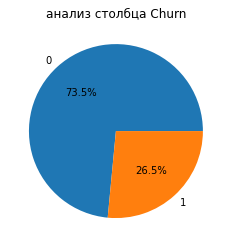

In [275]:
plt.pie(counts_churn.values(), labels=counts_churn.keys(), autopct='%1.1f%%')
plt.title('анализ столбца Churn')
plt.show()

In [276]:
train_x_y = pd.DataFrame.join(x_train,y_train, how='left')

churn_0 = train_x_y.loc[train_x_y[target_col] == 0]
churn_1 = train_x_y.loc[train_x_y[target_col] == 1]

In [277]:
upsamp_1 = resample(churn_1,n_samples=len(churn_0), replace=True)
upsamp = pd.concat([churn_0, upsamp_1], axis=0)

In [278]:
counts_churn = Counter(upsamp[target_col])

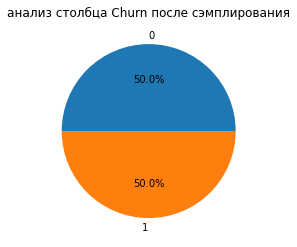

In [279]:
plt.pie(counts_churn.values(), labels=counts_churn.keys(), autopct='%1.1f%%')
plt.title('анализ столбца Churn после сэмплирования')
plt.show()

In [280]:
train_x_samp = upsamp[cols]
train_y_samp = upsamp[target_col]
x_train, x_val, y_train, y_val = train_test_split(train_x_samp, train_y_samp, train_size=0.7)

## Дискриминантный анализ

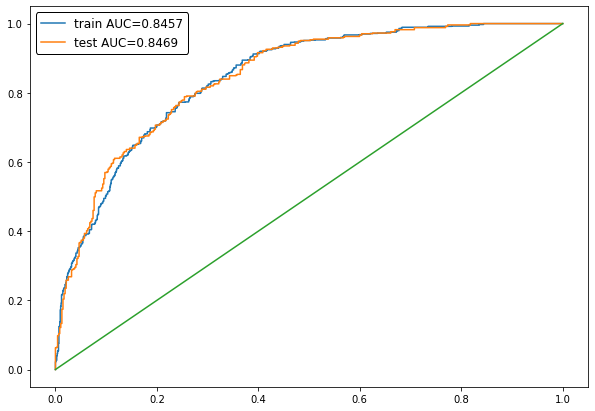

In [281]:
lda = LinearDiscriminantAnalysis()

cv = cross_validate(lda, x_train, y_train,
                    scoring='roc_auc', return_estimator=True)

best_place = cv['test_score'].argmax()
all_est = cv['estimator']
ldaa = all_est[best_place]
y_val_predicted_ldaa = ldaa.predict_proba(x_val)[:, 1]
y_train_predicted_ldaa = ldaa.predict_proba(x_train)[:, 1]
roc_auc_plot(y_train, y_train_predicted_ldaa, y_val,
             y_val_predicted_ldaa)

## Логистическая регрессия

Подберём лучшие параметры для нашей модели

In [282]:
parametrs = { 'C':[1.0, 0.0, 0.1, 0.01],
              'penalty': ['l1', 'l2']
            }

grid = GridSearchCV(estimator = LogisticRegression(), param_grid = parametrs, scoring='roc_auc', cv=5)
m = grid.fit(x_train, y_train)

grid.best_params_

{'C': 0.01, 'penalty': 'l2'}

In [283]:
LR = LogisticRegression(penalty='l2', C=0.1).fit(x_train, y_train)

In [284]:
y_val_predicted_regression = LR.predict_proba(x_val)[:, 1]
y_train_predicted_regression = LR.predict_proba(x_train)[:, 1]

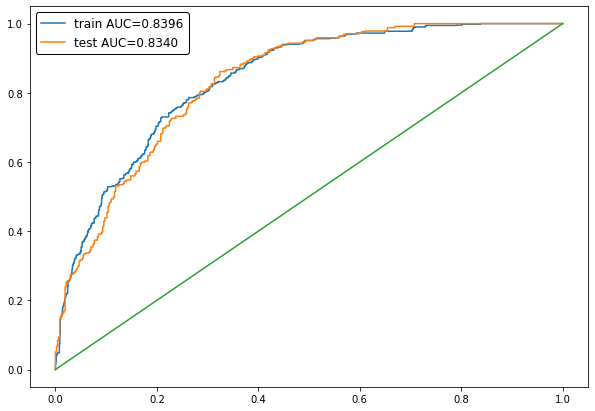

In [285]:
roc_auc_plot(y_train, y_train_predicted_regression, y_val, y_val_predicted_regression)

Модель обучили теперь можно и предсказать колонку 'Churn' для test

In [286]:
# сохраним колонку с id, для файла с ответом
test_id = test['id']
test = test[cols]
y_test_predicted_lr = ldaa.predict_proba(test)[:, 1]

In [287]:
def create_submission(id_col, y_pred):
    submission = pd.DataFrame({
        'id': id_col,
        'Churn': y_pred
    })
    return submission

In [288]:
sub = create_submission(test_id, y_test_predicted_lr)

In [289]:
sub

,id,Churn
0,2258,0.198785
1,3864,0.321693
2,1391,0.855821
3,486,0.933548
4,970,0.165361
...,...,...
2108,1700,0.536878
2109,1865,0.492167
2110,478,0.032290
2111,1227,0.895876


In [290]:
# сохраним файл с ответом и загрузим его для на kaggle
sub.to_csv("output/sub.csv", index=False)

### Перейдем на наше соревнование и загрузим ответ
Для этого:
1. Нажимаем на Submit Predictions
2. Загружаем файл с ответом
3. Нажимаем make Submsission
4. Показывается наш результат
5. Переходим во вкладку Leaderboard, что бы посмотреть на место, которые мы заняли

### Советы для улучшения результата
1. Построить графики для данных и поискать закономерности 
2. Нормальная предобработка признаков, отбор признаков, создание новых признаков
3. Попробовать другие модели
4. Перебор параметров для моделей
5. Погуглить про задачу и посмотреть, как люди подходят к решению задачи классификации